# 0. Initial set up

In [1]:
import os
import sys
import warnings
from SOBER._utils import TensorManager
tm = TensorManager()
sys.path.append(os.path.join(os.getcwd(), '..'))
warnings.filterwarnings('ignore')

# 1. Set up the problem.
## 1.1 define the domain, bounds

In [2]:
import torch

# set bounds
# Assume our bounds are standardised for statistical model.
# e.g. originally SOC [0, 100] but convert to [-2, 3], for better fitting.
bounds = torch.tensor([
    [-2, -2], # lower bound 
    [3, 3], # upper bound
])

# set label names
label_names = ["SOC", "Temp"]

# set prior
from SOBER._prior import Uniform    # Import prior from SOBER libraries
prior = Uniform(bounds)

## 1.2 define the synthetic lifetime function

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# We set threshold that defines good/bad battery
threshold_lifetime = 2

def synthetic_lifetime(X):
    # synthetic lifetime in years.
    # We assume over 2 years are good one.
    return (torch.sin(0.15 * torch.pi * X.sum(axis=1))+threshold_lifetime).unsqueeze(-1)

# visualising parameters
colour_map = 'jet'
resolution = 200

def get_plotting_domain():
    x = torch.linspace(bounds[0][0], bounds[1][0], resolution)
    y = torch.linspace(bounds[0][1], bounds[1][1], resolution)
    x_grid, y_grid = torch.meshgrid(x, y)
    X_grid = torch.dstack([x_grid, y_grid]).reshape(resolution**2, 2)
    return tm.standardise_tensor(X_grid)

def plot_function(data, ax):
    data = tm.numpy(data).reshape(resolution, resolution)
    image = ax.imshow(
        data,
        cmap=plt.get_cmap(colour_map),
        vmin=data.min(),
        vmax=data.max(),
        extent=[bounds[0][1], bounds[1][1], bounds[0][0], bounds[1][0]],
        interpolation='nearest',
        origin='lower',
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    #fig.colorbar(aximg, cax=cax)
    cbar = plt.colorbar(image, cax=cax)
    ax.set_xlabel(label_names[1])
    ax.set_ylabel(label_names[0])
    
def plot_white(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=10, color="white")

def plot_gold(X, ax):
    X = tm.numpy(X) # transform to numpy
    ax.scatter(X[:,1], X[:,0], s=30, marker="+", color="gold")

## 1.3 Visualising the synthetic classification problem

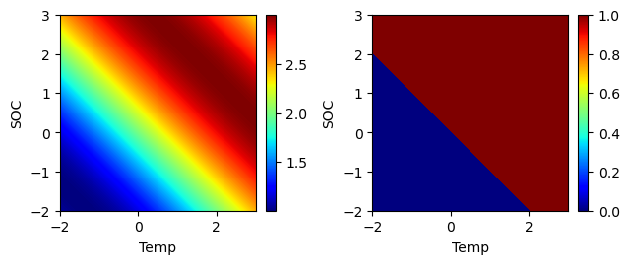

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, tight_layout=True)
Xgrid = get_plotting_domain()
Ygrid = synthetic_lifetime(Xgrid)
plot_function(Ygrid, ax1)
plot_function(Ygrid > 2, ax2)
plt.show()

# 2. Set up a Gaussian Process model

In [5]:
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

def setting_GP_model(X, Y):
    model = SingleTaskGP(X, Y) # setting GP model
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll) # optimize GP hyperparameters
    return model

def prediction(model, X):
    posterior = model.posterior(X)
    prob = torch.distributions.Normal(0,1).cdf(posterior.mean.squeeze() / posterior.stddev)
    var = prob * (1 - prob) # Bernoulli likelihood
    return prob, var, posterior.stddev

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## 2.1 generate the initial dataset.

In [6]:
seed = 2024
n_initial = 15
torch.random.manual_seed(seed)

X = prior.sample(n_initial)
Y = synthetic_lifetime(X) - threshold_lifetime
model = setting_GP_model(X, Y)

## 2.2 visualise the estimation results

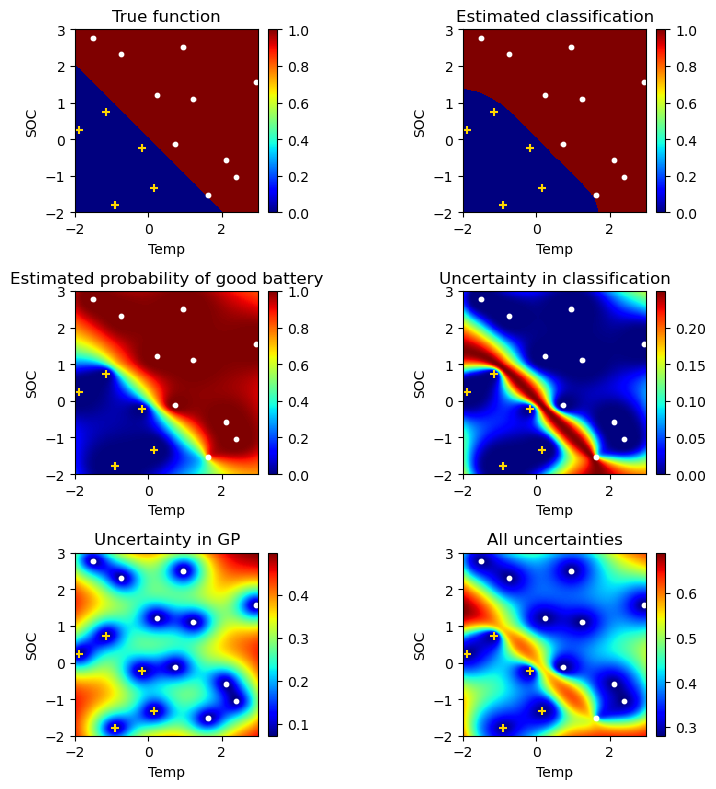

In [7]:
fig, axes = plt.subplots(3,2, tight_layout=True, figsize=(8,8))

plot_function(Ygrid > 2, axes[0,0])
plot_white(X[Y.squeeze() > 0], axes[0,0])
plot_gold(X[Y.squeeze() < 0], axes[0,0])
axes[0,0].set_title("True function")

prob, var, stddev = prediction(model, Xgrid)

plot_function(prob > 0.5, axes[0,1])
plot_white(X[Y.squeeze() > 0], axes[0,1])
plot_gold(X[Y.squeeze() < 0], axes[0,1])
axes[0,1].set_title("Estimated classification")

plot_function(prob, axes[1,0])
plot_white(X[Y.squeeze() > 0], axes[1,0])
plot_gold(X[Y.squeeze() < 0], axes[1,0])
axes[1,0].set_title("Estimated probability of good battery")

plot_function(var, axes[1,1])
plot_white(X[Y.squeeze() > 0], axes[1,1])
plot_gold(X[Y.squeeze() < 0], axes[1,1])
axes[1,1].set_title("Uncertainty in classification")

plot_function(stddev, axes[2,0])
plot_white(X[Y.squeeze() > 0], axes[2,0])
plot_gold(X[Y.squeeze() < 0], axes[2,0])
axes[2,0].set_title("Uncertainty in GP")

plot_function(torch.distributions.Normal(0,1).cdf(stddev).pow(2) + var, axes[2,1])
plot_white(X[Y.squeeze() > 0], axes[2,1])
plot_gold(X[Y.squeeze() < 0], axes[2,1])
axes[2,1].set_title("All uncertainties")

plt.show()

# 3. Try out different GP model. GP Binary classifier
In section 2, we assume we can get continuous values of lifetime. Now, we assume we can only have the access to binary labels (good or bad).

In [8]:
import gpytorch
from gpytorch.models import ExactGP
from gpytorch.likelihoods import DirichletClassificationLikelihood
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RFFKernel

# We will use the simplest form of GP model, exact inference
class DirichletGPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood, num_classes):
        super(DirichletGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(batch_shape=torch.Size((num_classes,)))
        self.covar_module = ScaleKernel(
            RFFKernel(num_samples=256, batch_shape=torch.Size((num_classes,))),
            batch_shape=torch.Size((num_classes,)),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
    
def set_GP_model(X, Y):
    train_x = X.float()
    train_y = (Y > 0).long().squeeze()

    # initialize likelihood and model
    # we let the DirichletClassificationLikelihood compute the targets for us
    likelihood = DirichletClassificationLikelihood(train_y, learn_additional_noise=True)
    model = DirichletGPModel(train_x, likelihood.transformed_targets, likelihood, num_classes=likelihood.num_classes)
    return model, likelihood, train_x

def train_GP_model(model, likelihood, train_x, training_iter=100):
    # Find optimal model hyperparameters
    model.train()
    likelihood.train()

    # Use the adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

    # "Loss" for GPs - the marginal log likelihood
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for i in range(training_iter):
        # Zero gradients from previous iteration
        optimizer.zero_grad()
        # Output from model
        output = model(train_x)
        # Calc loss and backprop gradients
        loss = -mll(output, likelihood.transformed_targets).sum()
        loss.backward()
        """
        if i % 5 == 0:
            print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
                i + 1, training_iter, loss.item(),
                model.covar_module.base_kernel.lengthscale.mean().item(),
                model.likelihood.second_noise_covar.noise.mean().item()
            ))
        """
        optimizer.step()
    model.eval()
    likelihood.eval()
    return model

def set_and_train_GP(X, Y):
    model, likelihood, train_x = set_GP_model(X, Y)
    model = train_GP_model(model, likelihood, train_x)
    return model

def prediction(model, X):
    with gpytorch.settings.fast_pred_var(), torch.no_grad():
        posterior = model(X.float())
    
    pred_samples = posterior.sample(torch.Size((256,))).exp()
    pred_samples /= pred_samples.sum(-2, keepdim=True)
    prob = pred_samples.mean(0)[1]
    var = prob * (1 - prob) # Bernoulli likelihood
    var_f = pred_samples[:,1,:].var(axis=0)
    return prob, var, var_f

## 3.1 generate the initial dataset.

In [9]:
seed = 2024
n_initial = 15
torch.random.manual_seed(seed)

X = prior.sample(n_initial)
Y = synthetic_lifetime(X) - threshold_lifetime
model = set_and_train_GP(X, Y)

## 3.2 visualise the estimation results

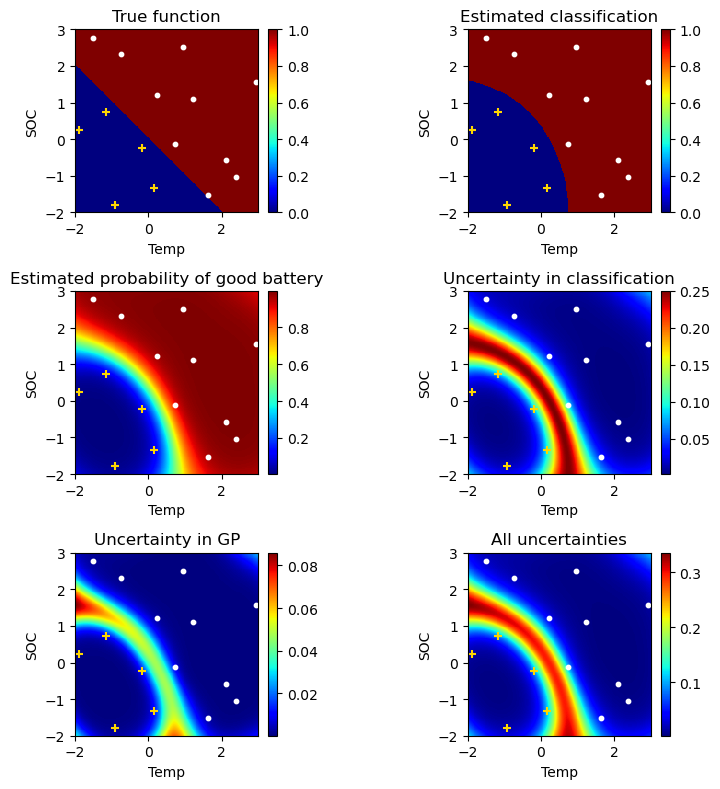

In [10]:
fig, axes = plt.subplots(3,2, tight_layout=True, figsize=(8,8))

plot_function(Ygrid > 2, axes[0,0])
plot_white(X[Y.squeeze() > 0], axes[0,0])
plot_gold(X[Y.squeeze() < 0], axes[0,0])
axes[0,0].set_title("True function")

prob, var, var_f = prediction(model, Xgrid)

plot_function(prob > 0.5, axes[0,1])
plot_white(X[Y.squeeze() > 0], axes[0,1])
plot_gold(X[Y.squeeze() < 0], axes[0,1])
axes[0,1].set_title("Estimated classification")

plot_function(prob, axes[1,0])
plot_white(X[Y.squeeze() > 0], axes[1,0])
plot_gold(X[Y.squeeze() < 0], axes[1,0])
axes[1,0].set_title("Estimated probability of good battery")

plot_function(var, axes[1,1])
plot_white(X[Y.squeeze() > 0], axes[1,1])
plot_gold(X[Y.squeeze() < 0], axes[1,1])
axes[1,1].set_title("Uncertainty in classification")

plot_function(var_f, axes[2,0])
plot_white(X[Y.squeeze() > 0], axes[2,0])
plot_gold(X[Y.squeeze() < 0], axes[2,0])
axes[2,0].set_title("Uncertainty in GP")

plot_function(var_f + var, axes[2,1])
plot_white(X[Y.squeeze() > 0], axes[2,1])
plot_gold(X[Y.squeeze() < 0], axes[2,1])
axes[2,1].set_title("All uncertainties")

plt.show()